# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, ReLU
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Combining files

In [ ]:
# Load the datasets
dataset1 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2018.csv').values
dataset2 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2019.csv').values
dataset3 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2020.csv').values
dataset4 = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2021.csv').values


In [ ]:
dataset1

array([['01-01-2018 00:00', 80.423, 18.16, 174.542804],
       ['01-01-2018 00:15', 81.471, 18.064, 175.981604],
       ['01-01-2018 00:30', 82.675, 17.927, 178.636804],
       ...,
       ['31-12-2018 23:15', 61.66634545, 17.689, 181.6006],
       ['31-12-2018 23:30', 60.73270909, 17.818, 183.150424],
       ['31-12-2018 23:45', 60.94089091, 17.827, 183.731516]],
      dtype=object)

In [ ]:
# Combine the datasets into a single array
combined_data = np.concatenate((dataset1, dataset2, dataset3), axis=0)

# Save the combined data as an npy file
np.save('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_data_181920.npy', combined_data)

# Checking missing rows

In [ ]:
import pandas as pd

# Read the data from the CSV file
data_r = pd.read_csv('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/2018.csv')

# Convert 'DateTime' column to datetime format
data_r['DateTime'] = pd.to_datetime(data_r['DateTime'], format='%d-%m-%Y %H:%M')

# Set 'DateTime' as the index
data_r.set_index('DateTime', inplace=True)

# Define the expected frequency (15 minutes)
expected_freq = pd.Timedelta(minutes=15)

# Generate the expected datetime range
expected_range = pd.date_range(start=data_r.index.min(), end=data_r.index.max(), freq=expected_freq)

# Find the missing rows
missing_rows = expected_range[~expected_range.isin(data_r.index)]

# Print the missing rows
print("Missing rows:")
for row in missing_rows:
    print(row)

Missing rows:


# Data preparation

In [ ]:
data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_data_181920.npy', allow_pickle=True)

In [ ]:
data.shape

(105216, 4)

In [ ]:
data

array([['01-01-2018 00:00', 80.423, 18.16, 174.542804],
       ['01-01-2018 00:15', 81.471, 18.064, 175.981604],
       ['01-01-2018 00:30', 82.675, 17.927, 178.636804],
       ...,
       ['31-12-2020 23:15', 82.6, 24.0, 169.591304],
       ['31-12-2020 23:30', 82.37, 24.03, 170.745392],
       ['31-12-2020 23:45', 82.5, 24.03, 170.80004]], dtype=object)

In [ ]:
# data = np.delete(data, 0, axis=1)
# # data = np.delete(data, 1, axis=1)
# # data = np.delete(data, 3, axis=1)

In [ ]:
columns_to_delete = [0,1,3]
data = np.delete(data, columns_to_delete, axis=1)

In [ ]:
data = data.astype(np.float32)
data
np.save('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_temp_data_181920.npy', data)

In [ ]:
temp_data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_temp_data_181920.npy', allow_pickle=True)
# RH_data = np.load('/content/combined_RH_data.npy', allow_pickle=True)

In [ ]:
temp_data.shape

(105216, 1)

In [ ]:
temp_data

array([[18.16 ],
       [18.064],
       [17.927],
       ...,
       [24.   ],
       [24.03 ],
       [24.03 ]], dtype=float32)

# Preprocessing

In [ ]:
temp_data = np.load('/content/drive/MyDrive/IMD-TP Load Forecast/Yearly Data/combined_temp_data_181920.npy', allow_pickle=True)

In [ ]:
temp_data.shape

(105216, 1)

In [ ]:
temp_data

array([[18.16 ],
       [18.064],
       [17.927],
       ...,
       [24.   ],
       [24.03 ],
       [24.03 ]], dtype=float32)

In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(temp_data)

In [ ]:
scaled_data

array([[0.47242457],
       [0.46992713],
       [0.46636316],
       ...,
       [0.62434965],
       [0.6251301 ],
       [0.6251301 ]], dtype=float32)

In [ ]:
scaled_data.shape

(105216, 1)

In [ ]:
# Preprocess the data
n_steps_in = 96 * 7  # Number of steps to take as input
n_steps_out = 96  # Number of steps to predict


# Reshape the data into input and target sequences
X, y = [], []
for i in range(n_steps_in, len(scaled_data) - 192):
    X.append(scaled_data[i - n_steps_in:i])
    y.append(scaled_data[i:i + 192])  # Extract the first column of the target data

X = np.array(X)
y = np.array(y)
y = y.reshape(y.shape[0],y.shape[1]*y.shape[2])

In [ ]:
split_index = int(0.80 * len(X))  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
len(scaled_data)

105216

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(83481, 672, 1)
(20871, 672, 1)
(83481, 192)
(20871, 192)


# Denormalizing

In [ ]:
# Denormalising or Rescaling
tempy = []
for i in range(672 ,RH_data.shape[0] - 192):
  tempy.append(RH_data[i:i+192])
tempy = np.array(tempy)
y_train_og, y_test_og = train_test_split(tempy,test_size=0.2,shuffle=False)

In [ ]:
y_train_og.shape

(83481, 192, 1)

In [ ]:
y_test_og.shape

(20871, 192, 1)

In [ ]:
tempy.shape

(104352, 192, 1)

In [ ]:
y_test_og = y_test_og.reshape(y_test_og.shape[0],y_test_og.shape[1],y_test_og.shape[2])
y_test_og.shape

(20871, 192, 1)

In [ ]:
tempy=tempy.reshape(tempy.shape[0],tempy.shape[1]*tempy.shape[2])
tempy.shape

(104352, 192)

In [ ]:
# y_test_og = y_test_og.reshape(y_test_og.shape[0],y_test_og.shape[1],y_test_og.shape[2])
# tempy=tempy.reshape(tempy.shape[0],tempy.shape[1]*tempy.shape[2])
scalery = MinMaxScaler()
models=scalery.fit(tempy)
sc_data=models.transform(tempy)

# ANN optuna

In [ ]:
%pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
def create_model(trial):

  # Create the ANN model
  model = Sequential()
  model.add(Dense(units=(trial.suggest_int('ann_1_units',y_train.shape[1], X_train.shape[1])), activation='relu', input_dim=X_train.shape[1]))
  model.add(Dense(units=(trial.suggest_int('ann_2_units',y_train.shape[1], X_train.shape[1])),activation='relu'))
  model.add(Dense(units=(trial.suggest_int('ann_3_units',y_train.shape[1], X_train.shape[1])),activation='relu'))
  # ann.add(tf.keras.layers.Dense(units=(trial.suggest_int('ann_2_units',y_train.shape[1], X_train.shape[1])),activation="relu"))
  model.add(tf.keras.layers.Dense(y_train.shape[1], activation='tanh'))

  # Compile the model
  optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
  # optimizer = tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True))
  # model.compile(optimizer=optimizer_name, loss='mse', metrics=['mse'])
  model.compile(optimizer=optimizer_name, loss="binary_crossentropy",metrics=['accuracy'])

  return model

def objective(trial):
    model = create_model(trial)
    epochs = trial.suggest_int("epochs", 5, 50,step=5, log=False)
    batchsize = trial.suggest_int("batchsize", 5, 50,step=5, log=False)

    # Train the model
    model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs)

    # Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    return scores[1]

study = optuna.create_study()
study.optimize(objective, n_trials=10)

print(study.best_params)

[I 2023-07-21 16:45:57,062] A new study created in memory with name: no-name-8ac04a77-04aa-4a21-8456-13dd4271b811


Epoch 1/45
1670/1670 [==============================] - 9s 4ms/step - loss: 1.8187 - accuracy: 0.0139
Epoch 2/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.5974 - accuracy: 0.0363
Epoch 3/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.5967 - accuracy: 0.0428
Epoch 4/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.3716 - accuracy: 0.0400
Epoch 5/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.1271 - accuracy: 0.0470
Epoch 6/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.1194 - accuracy: 0.0477
Epoch 7/45
1670/1670 [==============================] - 6s 4ms/step - loss: 1.0747 - accuracy: 0.0509
Epoch 8/45
1670/1670 [==============================] - 9s 5ms/step - loss: 1.0746 - accuracy: 0.0514
Epoch 9/45
1670/1670 [==============================] - 7s 4ms/step - loss: 1.0746 - accuracy: 0.0524
Epoch 10/45
1670/1670 [==============================] - 7s 4ms/step - loss: 0.868

[I 2023-07-21 16:51:21,707] Trial 0 finished with value: 0.028173062950372696 and parameters: {'ann_1_units': 626, 'ann_2_units': 329, 'ann_3_units': 500, 'optimizer': 'adam', 'epochs': 45, 'batchsize': 50}. Best is trial 0 with value: 0.028173062950372696.


Epoch 1/10
5566/5566 [==============================] - 24s 4ms/step - loss: 1.2743 - accuracy: 0.0322
Epoch 2/10
5566/5566 [==============================] - 21s 4ms/step - loss: 1.0545 - accuracy: 0.0441
Epoch 3/10
5566/5566 [==============================] - 23s 4ms/step - loss: 0.8630 - accuracy: 0.0466
Epoch 4/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.7723 - accuracy: 0.0486
Epoch 5/10
5566/5566 [==============================] - 22s 4ms/step - loss: 0.7620 - accuracy: 0.0517
Epoch 6/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.7619 - accuracy: 0.0526
Epoch 7/10
5566/5566 [==============================] - 23s 4ms/step - loss: 0.7619 - accuracy: 0.0521
Epoch 8/10
5566/5566 [==============================] - 22s 4ms/step - loss: 0.7618 - accuracy: 0.0515
Epoch 9/10
5566/5566 [==============================] - 22s 4ms/step - loss: 0.7617 - accuracy: 0.0533
Epoch 10/10
5566/5566 [==============================] - 24s 4ms/step - l

[I 2023-07-21 16:55:46,264] Trial 1 finished with value: 0.026160702109336853 and parameters: {'ann_1_units': 467, 'ann_2_units': 486, 'ann_3_units': 428, 'optimizer': 'RMSprop', 'epochs': 10, 'batchsize': 15}. Best is trial 1 with value: 0.026160702109336853.


Epoch 1/10
5566/5566 [==============================] - 24s 4ms/step - loss: 1.3681 - accuracy: 0.0356
Epoch 2/10
5566/5566 [==============================] - 21s 4ms/step - loss: 1.0757 - accuracy: 0.0456
Epoch 3/10
5566/5566 [==============================] - 22s 4ms/step - loss: 0.9962 - accuracy: 0.0471
Epoch 4/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.9186 - accuracy: 0.0489
Epoch 5/10
5566/5566 [==============================] - 22s 4ms/step - loss: 0.9185 - accuracy: 0.0497
Epoch 6/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.9184 - accuracy: 0.0497
Epoch 7/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.8877 - accuracy: 0.0505
Epoch 8/10
5566/5566 [==============================] - 24s 4ms/step - loss: 0.8661 - accuracy: 0.0512
Epoch 9/10
5566/5566 [==============================] - 21s 4ms/step - loss: 0.8660 - accuracy: 0.0525
Epoch 10/10
5566/5566 [==============================] - 22s 4ms/step - l

[I 2023-07-21 17:00:10,796] Trial 2 finished with value: 0.024196254089474678 and parameters: {'ann_1_units': 489, 'ann_2_units': 232, 'ann_3_units': 622, 'optimizer': 'RMSprop', 'epochs': 10, 'batchsize': 15}. Best is trial 2 with value: 0.024196254089474678.


Epoch 1/40
1670/1670 [==============================] - 9s 4ms/step - loss: 2.1845 - accuracy: 0.0261
Epoch 2/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.5490 - accuracy: 0.0348
Epoch 3/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.2314 - accuracy: 0.0443
Epoch 4/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.2313 - accuracy: 0.0460
Epoch 5/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.1850 - accuracy: 0.0461
Epoch 6/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.1790 - accuracy: 0.0491
Epoch 7/40
1670/1670 [==============================] - 7s 4ms/step - loss: 1.0494 - accuracy: 0.0467
Epoch 8/40
1670/1670 [==============================] - 6s 4ms/step - loss: 0.9702 - accuracy: 0.0500
Epoch 9/40
1670/1670 [==============================] - 7s 4ms/step - loss: 0.9702 - accuracy: 0.0541
Epoch 10/40
1670/1670 [==============================] - 6s 4ms/step - loss: 0.970

[I 2023-07-21 17:04:49,403] Trial 3 finished with value: 0.029850030317902565 and parameters: {'ann_1_units': 454, 'ann_2_units': 429, 'ann_3_units': 325, 'optimizer': 'adam', 'epochs': 40, 'batchsize': 50}. Best is trial 2 with value: 0.024196254089474678.


Epoch 1/10
5566/5566 [==============================] - 23s 4ms/step - loss: 7.5313 - accuracy: 0.0075
Epoch 2/10
5566/5566 [==============================] - 21s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 3/10
5566/5566 [==============================] - 23s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 4/10
5566/5566 [==============================] - 22s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 5/10
5566/5566 [==============================] - 22s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 6/10
5566/5566 [==============================] - 22s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 7/10
5566/5566 [==============================] - 21s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 8/10
5566/5566 [==============================] - 22s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 9/10
5566/5566 [==============================] - 21s 4ms/step - loss: 7.5324 - accuracy: 0.0075
Epoch 10/10
5566/5566 [==============================] - 22s 4ms/step - l

[I 2023-07-21 17:08:30,983] Trial 4 finished with value: 0.0067078722640872 and parameters: {'ann_1_units': 355, 'ann_2_units': 584, 'ann_3_units': 244, 'optimizer': 'SGD', 'epochs': 10, 'batchsize': 15}. Best is trial 4 with value: 0.0067078722640872.


Epoch 1/10
2783/2783 [==============================] - 13s 4ms/step - loss: 2.3725 - accuracy: 0.0279
Epoch 2/10
2783/2783 [==============================] - 11s 4ms/step - loss: 1.9618 - accuracy: 0.0391
Epoch 3/10
2783/2783 [==============================] - 10s 3ms/step - loss: 1.8582 - accuracy: 0.0431
Epoch 4/10
2783/2783 [==============================] - 13s 5ms/step - loss: 1.8579 - accuracy: 0.0458
Epoch 5/10
2783/2783 [==============================] - 11s 4ms/step - loss: 1.8577 - accuracy: 0.0472
Epoch 6/10
2783/2783 [==============================] - 11s 4ms/step - loss: 1.8269 - accuracy: 0.0474
Epoch 7/10
2783/2783 [==============================] - 11s 4ms/step - loss: 1.7532 - accuracy: 0.0475
Epoch 8/10
2783/2783 [==============================] - 10s 4ms/step - loss: 1.7531 - accuracy: 0.0482
Epoch 9/10
2783/2783 [==============================] - 11s 4ms/step - loss: 1.7531 - accuracy: 0.0492
Epoch 10/10
2783/2783 [==============================] - 11s 4ms/step - l

[I 2023-07-21 17:10:24,963] Trial 5 finished with value: 0.023046331480145454 and parameters: {'ann_1_units': 260, 'ann_2_units': 205, 'ann_3_units': 329, 'optimizer': 'RMSprop', 'epochs': 10, 'batchsize': 30}. Best is trial 4 with value: 0.0067078722640872.


Epoch 1/35
2088/2088 [==============================] - 11s 4ms/step - loss: 1.7793 - accuracy: 0.0222
Epoch 2/35
2088/2088 [==============================] - 8s 4ms/step - loss: 1.5446 - accuracy: 0.0451
Epoch 3/35
2088/2088 [==============================] - 9s 4ms/step - loss: 1.5444 - accuracy: 0.0469
Epoch 4/35
2088/2088 [==============================] - 9s 4ms/step - loss: 1.2284 - accuracy: 0.0456
Epoch 5/35
2088/2088 [==============================] - 8s 4ms/step - loss: 1.0225 - accuracy: 0.0500
Epoch 6/35
2088/2088 [==============================] - 9s 4ms/step - loss: 1.0224 - accuracy: 0.0535
Epoch 7/35
2088/2088 [==============================] - 8s 4ms/step - loss: 1.0115 - accuracy: 0.0523
Epoch 8/35
2088/2088 [==============================] - 9s 4ms/step - loss: 0.9181 - accuracy: 0.0534
Epoch 9/35
2088/2088 [==============================] - 9s 4ms/step - loss: 0.9180 - accuracy: 0.0545
Epoch 10/35
2088/2088 [==============================] - 8s 4ms/step - loss: 0.91

[I 2023-07-21 17:15:33,242] Trial 6 finished with value: 0.029802117496728897 and parameters: {'ann_1_units': 299, 'ann_2_units': 438, 'ann_3_units': 340, 'optimizer': 'adam', 'epochs': 35, 'batchsize': 40}. Best is trial 4 with value: 0.0067078722640872.


Epoch 1/30
2088/2088 [==============================] - 9s 4ms/step - loss: 2.0437 - accuracy: 0.0212
Epoch 2/30
2088/2088 [==============================] - 8s 4ms/step - loss: 1.4408 - accuracy: 0.0389
Epoch 3/30
2088/2088 [==============================] - 9s 4ms/step - loss: 1.3892 - accuracy: 0.0439
Epoch 4/30
2088/2088 [==============================] - 10s 5ms/step - loss: 1.1890 - accuracy: 0.0427
Epoch 5/30
2088/2088 [==============================] - 9s 4ms/step - loss: 1.1278 - accuracy: 0.0465
Epoch 6/30
2088/2088 [==============================] - 9s 4ms/step - loss: 1.0755 - accuracy: 0.0466
Epoch 7/30
2088/2088 [==============================] - 8s 4ms/step - loss: 1.0753 - accuracy: 0.0487
Epoch 8/30
2088/2088 [==============================] - 9s 4ms/step - loss: 1.0239 - accuracy: 0.0474
Epoch 9/30
2088/2088 [==============================] - 7s 4ms/step - loss: 0.9866 - accuracy: 0.0485
Epoch 10/30
2088/2088 [==============================] - 10s 5ms/step - loss: 0.9

[I 2023-07-21 17:19:59,187] Trial 7 finished with value: 0.021321451291441917 and parameters: {'ann_1_units': 412, 'ann_2_units': 386, 'ann_3_units': 443, 'optimizer': 'RMSprop', 'epochs': 30, 'batchsize': 40}. Best is trial 4 with value: 0.0067078722640872.


Epoch 1/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8654 - accuracy: 0.0244
Epoch 2/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8685 - accuracy: 0.0244
Epoch 3/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8685 - accuracy: 0.0244
Epoch 4/45
2386/2386 [==============================] - 9s 4ms/step - loss: 7.8685 - accuracy: 0.0244
Epoch 5/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8686 - accuracy: 0.0244
Epoch 6/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8686 - accuracy: 0.0244
Epoch 7/45
2386/2386 [==============================] - 9s 4ms/step - loss: 7.8686 - accuracy: 0.0244
Epoch 8/45
2386/2386 [==============================] - 9s 4ms/step - loss: 7.8685 - accuracy: 0.0244
Epoch 9/45
2386/2386 [==============================] - 10s 4ms/step - loss: 7.8685 - accuracy: 0.0244
Epoch 10/45
2386/2386 [==============================] - 9s 4ms/step - loss:

[I 2023-07-21 17:27:23,775] Trial 8 finished with value: 0.01940491609275341 and parameters: {'ann_1_units': 274, 'ann_2_units': 307, 'ann_3_units': 412, 'optimizer': 'SGD', 'epochs': 45, 'batchsize': 35}. Best is trial 4 with value: 0.0067078722640872.


Epoch 1/35
1856/1856 [==============================] - 10s 4ms/step - loss: 3.0676 - accuracy: 0.0065
Epoch 2/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9601 - accuracy: 0.0103
Epoch 3/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9598 - accuracy: 0.0112
Epoch 4/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9595 - accuracy: 0.0109
Epoch 5/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9592 - accuracy: 0.0108
Epoch 6/35
1856/1856 [==============================] - 7s 4ms/step - loss: 2.9589 - accuracy: 0.0108
Epoch 7/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9585 - accuracy: 0.0112
Epoch 8/35
1856/1856 [==============================] - 7s 4ms/step - loss: 2.9581 - accuracy: 0.0123
Epoch 9/35
1856/1856 [==============================] - 8s 4ms/step - loss: 2.9577 - accuracy: 0.0129
Epoch 10/35
1856/1856 [==============================] - 7s 4ms/step - loss: 2.95

[I 2023-07-21 17:32:48,925] Trial 9 finished with value: 0.023477552458643913 and parameters: {'ann_1_units': 220, 'ann_2_units': 280, 'ann_3_units': 225, 'optimizer': 'SGD', 'epochs': 35, 'batchsize': 45}. Best is trial 4 with value: 0.0067078722640872.


{'ann_1_units': 355, 'ann_2_units': 584, 'ann_3_units': 244, 'optimizer': 'SGD', 'epochs': 10, 'batchsize': 15}


# ANN model building

In [ ]:
# Build the ANN model
model = Sequential()
model.add(Dense(units=355, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=584, activation='relu'))
model.add(Dense(units=244, activation='relu'))
model.add(Dense(units=y_train.shape[1], activation='tanh'))

# Compile the model
model.compile(optimizer='SGD', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=15, validation_split=0.2,verbose=1)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 355)               238915    
                                                                 
 dense_89 (Dense)            (None, 584)               207904    
                                                                 
 dense_90 (Dense)            (None, 244)               142740    
                                                                 
 dense_91 (Dense)            (None, 192)               47040     
                                                                 
Total params: 636,599
Trainable params: 636,599
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4453/4453 [==============================] - 18s 4ms/step - loss: 0.0132 - val_loss: 0.0082
Epoch 2/10
4453/4453 [==============================] - 17s 4ms/step - loss:

In [ ]:
# Evaluate the performance of the DNN model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

653/653 [==============================] - 1s 2ms/step - loss: 0.0086
Mean Squared Error: 0.00862911157310009


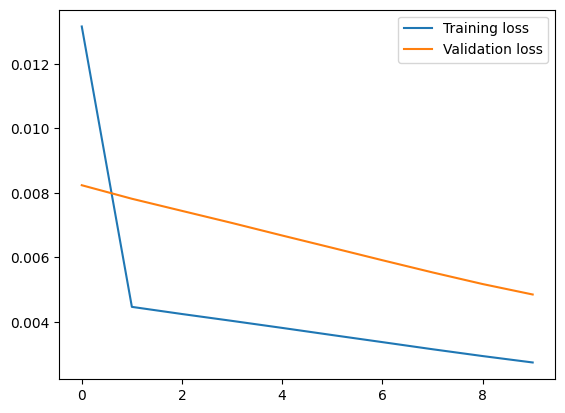

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Model saving

In [ ]:
model.save('/content/drive/MyDrive/IMD-TP Load Forecast/ANN/temp_181920_192.h5')

# Predictions

In [ ]:
model = load_model('/content/drive/MyDrive/IMD-TP Load Forecast/ANN/temp_181920_192.h5')

In [ ]:
X_test.shape

(20871, 672, 1)

In [ ]:
pred = model.predict(X_test[0:672])
pred

21/21 [==============================] - 0s 3ms/step


array([[0.72559404, 0.7004154 , 0.74487334, ..., 0.75030094, 0.78293574,
        0.74245673],
       [0.72437257, 0.697163  , 0.74238455, ..., 0.75017196, 0.7815018 ,
        0.741519  ],
       [0.7243328 , 0.6934707 , 0.7395956 , ..., 0.749101  , 0.77895224,
        0.7407153 ],
       ...,
       [0.73226047, 0.7058009 , 0.749589  , ..., 0.7580663 , 0.7780615 ,
        0.7371421 ],
       [0.73212415, 0.7025322 , 0.74515104, ..., 0.7583265 , 0.7763042 ,
        0.73644257],
       [0.7323661 , 0.7003979 , 0.7447001 , ..., 0.75798404, 0.7758009 ,
        0.73345894]], dtype=float32)

In [ ]:
len(pred)

672

In [ ]:
pred.shape

(672, 192)

In [ ]:
pred = pd.DataFrame(pred)
pred

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.725594,0.700415,0.744873,0.753347,0.734485,0.748762,0.728099,0.727221,0.728668,0.732814,...,0.759239,0.775252,0.788175,0.768791,0.744434,0.749673,0.741191,0.750301,0.782936,0.742457
1,0.724373,0.697163,0.742385,0.752454,0.731772,0.748416,0.726138,0.725172,0.726183,0.729608,...,0.755863,0.773304,0.786849,0.767049,0.743847,0.749227,0.737762,0.750172,0.781502,0.741519
2,0.724333,0.693471,0.739596,0.752254,0.728579,0.747158,0.724462,0.723649,0.724046,0.726479,...,0.752926,0.770731,0.783551,0.765793,0.742420,0.749164,0.733824,0.749101,0.778952,0.740715
3,0.723860,0.690252,0.738020,0.751263,0.726785,0.746155,0.721525,0.721282,0.722679,0.723921,...,0.749010,0.767130,0.780838,0.763421,0.741024,0.749592,0.730082,0.748975,0.776191,0.739077
4,0.723962,0.687826,0.736247,0.751265,0.725026,0.745918,0.719943,0.719172,0.720728,0.721639,...,0.744967,0.763956,0.776389,0.760244,0.738907,0.749943,0.727261,0.749266,0.773779,0.738560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.732858,0.715129,0.753983,0.749751,0.745152,0.743478,0.735021,0.733338,0.736766,0.740036,...,0.768298,0.768069,0.778177,0.769408,0.756566,0.744432,0.748939,0.758511,0.775975,0.738251
668,0.732931,0.709839,0.750778,0.751426,0.741876,0.741792,0.733310,0.732179,0.733084,0.734029,...,0.768848,0.769276,0.777248,0.767878,0.755423,0.740434,0.743705,0.760573,0.775134,0.738899
669,0.732260,0.705801,0.749589,0.751830,0.740444,0.742328,0.729557,0.725922,0.730166,0.731946,...,0.765595,0.768053,0.777075,0.765432,0.755317,0.740892,0.742529,0.758066,0.778062,0.737142
670,0.732124,0.702532,0.745151,0.752219,0.737420,0.743013,0.729199,0.725167,0.726221,0.729143,...,0.762953,0.769773,0.776226,0.764154,0.752742,0.739205,0.738874,0.758326,0.776304,0.736443


In [ ]:
from scipy.stats import pearsonr
kpcc = pearsonr(pred.flatten(), y_test.flatten())
kpcc

AttributeError: ignored

In [ ]:
y_test.flatten().shape

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
mape = mean_absolute_percentage_error(y_test, pred)
mape

In [ ]:
rmse = mean_squared_error(y_test, pred, squared=False)
rmse

# Denormalizing predictions

In [ ]:
pred_original = scalery.inverse_transform(pred)
pred_original
# tempy_inverse = tempy_inverse.reshape(tempy_inverse.shape[0], 96, 1)
# predictions = np.reshape(predictions, (predictions.shape[0], 7, input.shape[2]))
# pred_original

NameError: ignored

# LSTM

In [ ]:
model = Sequential()
model.add(LSTM(214, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(142, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='tanh'))
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
model.summary()
# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2,verbose=1)

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

KeyError: ignored

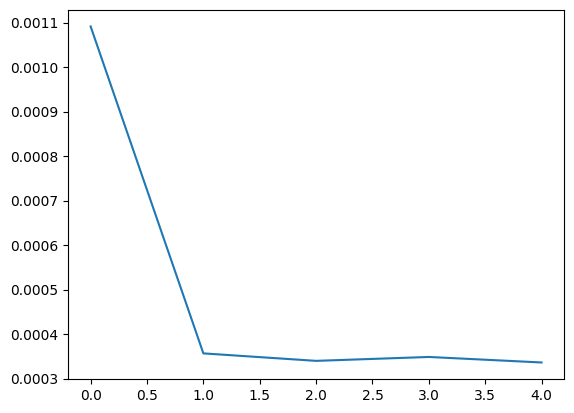

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Multi output model

In [ ]:
# Build the multi-output model
input_layer = Input(shape=(2,))
hidden_layer = Dense(64, activation='relu')(input_layer)
output1 = Dense(1, name='output1')(hidden_layer)  # Temperature prediction
output2 = Dense(1, name='output2')(hidden_layer)  # Humidity prediction
output3 = Dense(1, name='output3')(hidden_layer)  # Load prediction

model = Model(inputs=input_layer, outputs=[output1, output2, output3])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, [y_train_scaled, y_train_scaled, y_train_scaled],
          validation_data=(X_test_scaled, [y_test_scaled, y_test_scaled, y_test_scaled]),
          epochs=5, batch_size=32)

# # Predict on test data
# predictions = model.predict(X_test_scaled)

# # Rescale the predictions back to the original scale
# predictions_rescaled = [scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

# # Print the predicted values
# for i, pred in enumerate(predictions_rescaled):
#     print(f"Prediction for sample {i+1}: Temperature={pred[0]}, Humidity={pred[1]}, Load={pred[2]}")


Epoch 1/5
3153/3153 [==============================] - 13s 4ms/step - loss: 0.0653 - output1_loss: 0.0221 - output2_loss: 0.0210 - output3_loss: 0.0223 - val_loss: 0.0583 - val_output1_loss: 0.0195 - val_output2_loss: 0.0195 - val_output3_loss: 0.0194
Epoch 2/5
3153/3153 [==============================] - 13s 4ms/step - loss: 0.0571 - output1_loss: 0.0191 - output2_loss: 0.0190 - output3_loss: 0.0191 - val_loss: 0.0576 - val_output1_loss: 0.0192 - val_output2_loss: 0.0192 - val_output3_loss: 0.0192
Epoch 3/5
3153/3153 [==============================] - 9s 3ms/step - loss: 0.0570 - output1_loss: 0.0190 - output2_loss: 0.0190 - output3_loss: 0.0190 - val_loss: 0.0567 - val_output1_loss: 0.0189 - val_output2_loss: 0.0189 - val_output3_loss: 0.0189
Epoch 4/5
3153/3153 [==============================] - 12s 4ms/step - loss: 0.0566 - output1_loss: 0.0189 - output2_loss: 0.0189 - output3_loss: 0.0189 - val_loss: 0.0560 - val_output1_loss: 0.0186 - val_output2_loss: 0.0186 - val_output3_loss: 

In [ ]:
# Evaluate the performance of the DNN model
mse = model.evaluate(X_test_scaled, y_test_scaled)
print("Mean Squared Error:", mse)

1051/1051 [==============================] - 2s 2ms/step - loss: 0.0560 - output1_loss: 0.0187 - output2_loss: 0.0188 - output3_loss: 0.0186
Mean Squared Error: [0.05604485794901848, 0.018656382337212563, 0.01875092089176178, 0.018637558445334435]


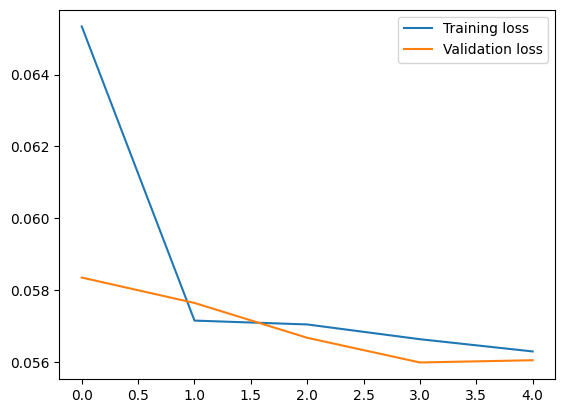

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
X_train_scaled.shape

(23424, 2)